In [25]:
import sys
!{sys.executable} -m pip install numpy opencv-python mediapipe torch matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [26]:
!python3 -m pip install -r requirements.txt  

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [27]:
import cv2
import numpy as np
import mediapipe as mp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [28]:
# ----------------------
# Config
# ----------------------
TARGET_SIZE = (224, 224)
SEQUENCE_LENGTH = 32
STRIDE = 16
USE_SKELETON = True
NUM_CLASSES = 5

In [29]:
# ----------------------
# Pose Estimation Setup
# ----------------------
mp_pose = mp.solutions.pose
pose_model = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

def extract_pose(frame):
    results = pose_model.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks:
        return np.zeros((33, 3))  # x, y, z
    return np.array([[l.x, l.y, l.z] for l in results.pose_landmarks.landmark])

I0000 00:00:1746232017.132443  958891 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3


In [30]:
# ----------------------
# Process Video Frames + Skeleton
# ----------------------
def process_video(video_path, use_pose=True):
    cap = cv2.VideoCapture(video_path)
    frames, keypoints = [], []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, TARGET_SIZE)

        if use_pose:
            # Pass original uint8 frame to extract_pose()
            keypoints.append(extract_pose(frame).flatten())

        # Normalize AFTER extracting pose
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)

    cap.release()
    return np.array(frames), np.array(keypoints) if use_pose else None

In [31]:
# ----------------------
# Create Fixed-Length Clips
# ----------------------
def create_clips(frames, keypoints=None, sequence_length=32, stride=16):
    clips, pose_clips = [], []
    for i in range(0, len(frames) - sequence_length + 1, stride):
        if keypoints is not None:
            pose_clip = keypoints[i:i + sequence_length]
            if len(pose_clip) == sequence_length:
                pose_clips.append(pose_clip)

    return np.array(pose_clips)

In [32]:
# ----------------------
# LSTM Model
# ----------------------
class PoseLSTM(nn.Module):
    def __init__(self, input_size=99, hidden_size=128, num_layers=2, num_classes=NUM_CLASSES):
        super(PoseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

In [33]:
# ----------------------
# Train Model
# ----------------------
def train_model(video_paths, labels):
    all_clips = []
    all_labels = []

    for i, video in enumerate(video_paths):
        _, keypoints = process_video(video, use_pose=True)
        pose_clips = create_clips(_, keypoints, sequence_length=SEQUENCE_LENGTH, stride=STRIDE)
        all_clips.extend(pose_clips)
        all_labels.extend([labels[i]] * len(pose_clips))

    X = torch.tensor(np.stack(all_clips)).float()
    y = torch.tensor(all_labels).long()

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=8, shuffle=True)

    model = PoseLSTM()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(5):
        for xb, yb in loader:
            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    return model

In [34]:

# ----------------------
# Predict on New Video
# ----------------------
def predict(video_path, model):
    _, keypoints = process_video(video_path, use_pose=True)
    pose_clips = create_clips(_, keypoints, sequence_length=SEQUENCE_LENGTH, stride=STRIDE)

    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(pose_clips).float()
        outputs = model(inputs)
        avg_probs = torch.softmax(outputs, dim=1).mean(dim=0)
        pred_class = torch.argmax(avg_probs).item()

    return pred_class, avg_probs.numpy()

In [35]:
# ----------------------
# Main
# ----------------------
if __name__ == "__main__":
    videos = ["testvideo.mp4"]
    # labels = [0, 1, 2, 0]  # Corresponding to each video

    # model = train_model(videos, labels)

    # pred, probs = predict("test_video.mp4", model)
    # print("Predicted label:", pred)
    # print("Confidence scores:", probs)
    _, keypoints = process_video(videos[0], use_pose=True)
    pose_clips = create_clips(_, keypoints, sequence_length=SEQUENCE_LENGTH, stride=STRIDE)
    print(len(pose_clips))

W0000 00:00:1746232017.271088  971698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746232017.288291  971698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


41


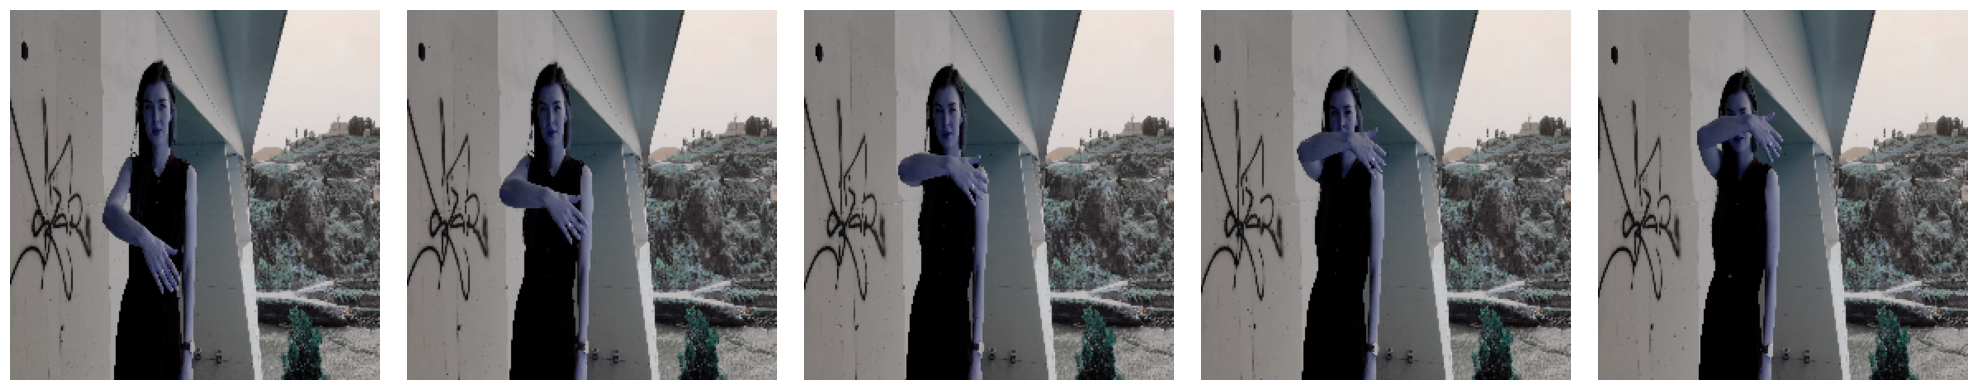

In [24]:
def show_video_clip(frames_clip):
    fig, axes = plt.subplots(1, len(frames_clip), figsize=(20, 4))
    for i, ax in enumerate(axes):
        ax.imshow(frames_clip[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_video_clip(_[0:5])

In [36]:
import matplotlib.pyplot as plt

# MediaPipe Pose connections for drawing lines between keypoints
POSE_CONNECTIONS = [
    (0,1), (1,2), (2,3), (3,4),       # Right arm
    (0,5), (5,6), (6,7), (7,8),       # Left arm
    (9,10),                           # Eyes
    (11,12), (11,13), (13,15),        # Left leg
    (12,14), (14,16),                 # Right leg
    (11,23), (12,24),                 # Hips to legs
    (23,24), (23,25), (24,26),        # Legs
    (25,27), (26,28), (27,29), (28,30),  # Knees
    (15,17), (16,18), (17,19), (18,20),  # Hands
]

def plot_skeleton(keypoints_33x3, ax):
    x = keypoints_33x3[:, 0]
    y = -keypoints_33x3[:, 1]  # Flip y for better orientation
    ax.scatter(x, y, c='r', s=10)
    for start, end in POSE_CONNECTIONS:
        ax.plot([x[start], x[end]], [y[start], y[end]], 'b')

def show_pose_clip(pose_clip):
    fig, axes = plt.subplots(1, len(pose_clip), figsize=(20, 4))
    for i, ax in enumerate(axes):
        keypoints = pose_clip[i].reshape(33, 3)
        plot_skeleton(keypoints, ax)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


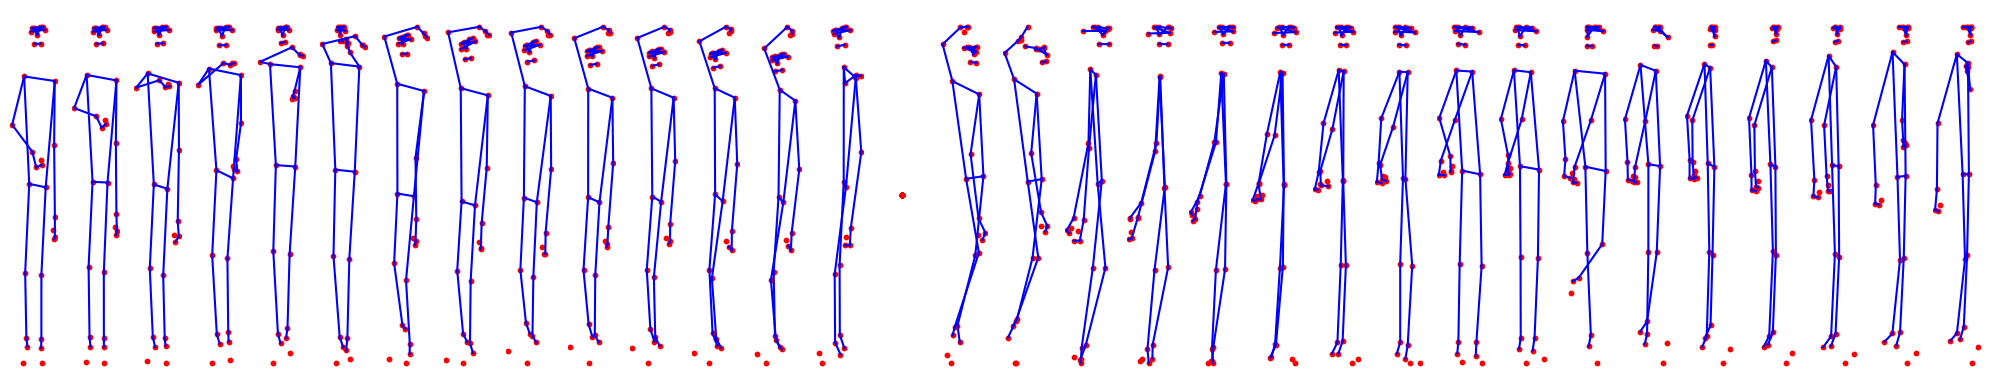

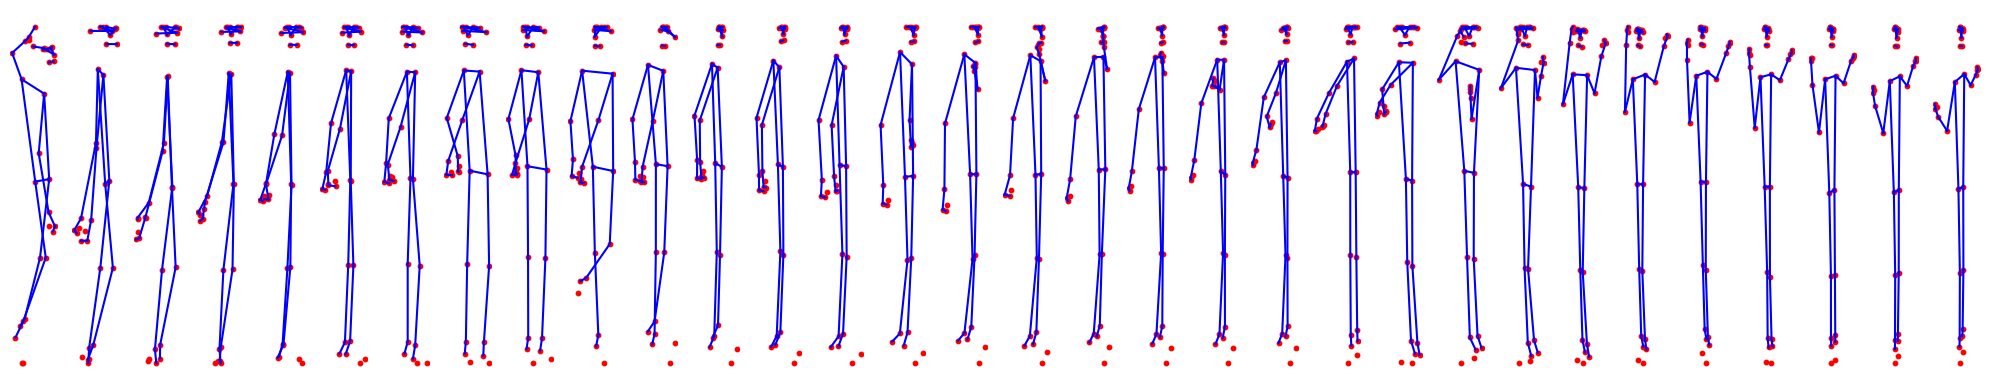

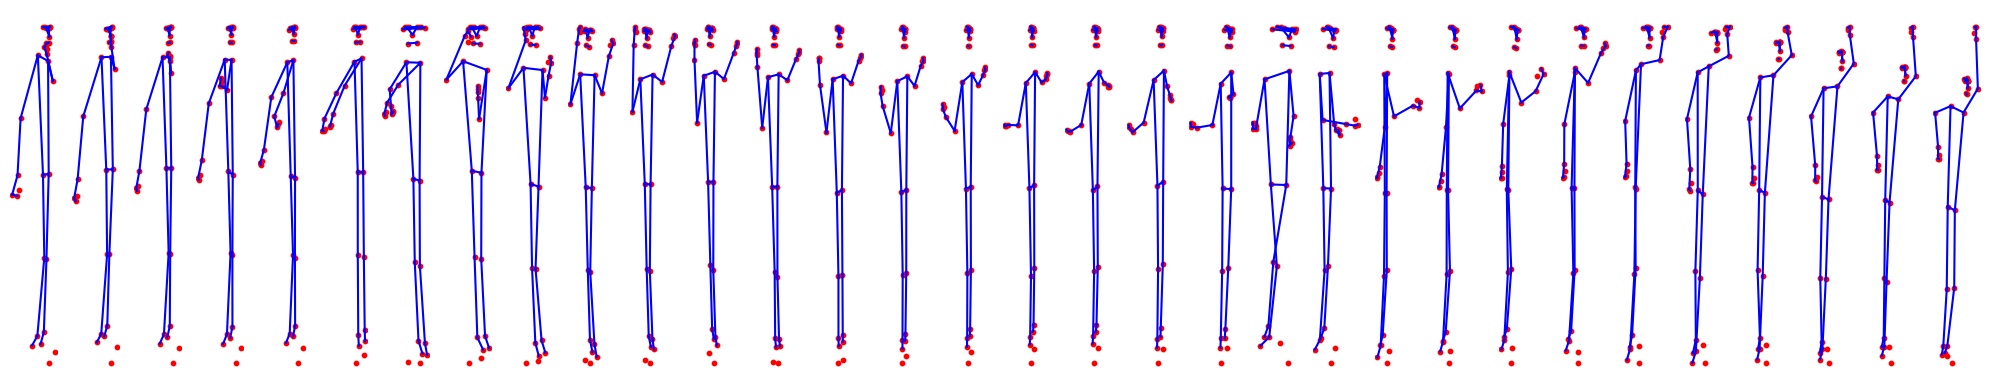

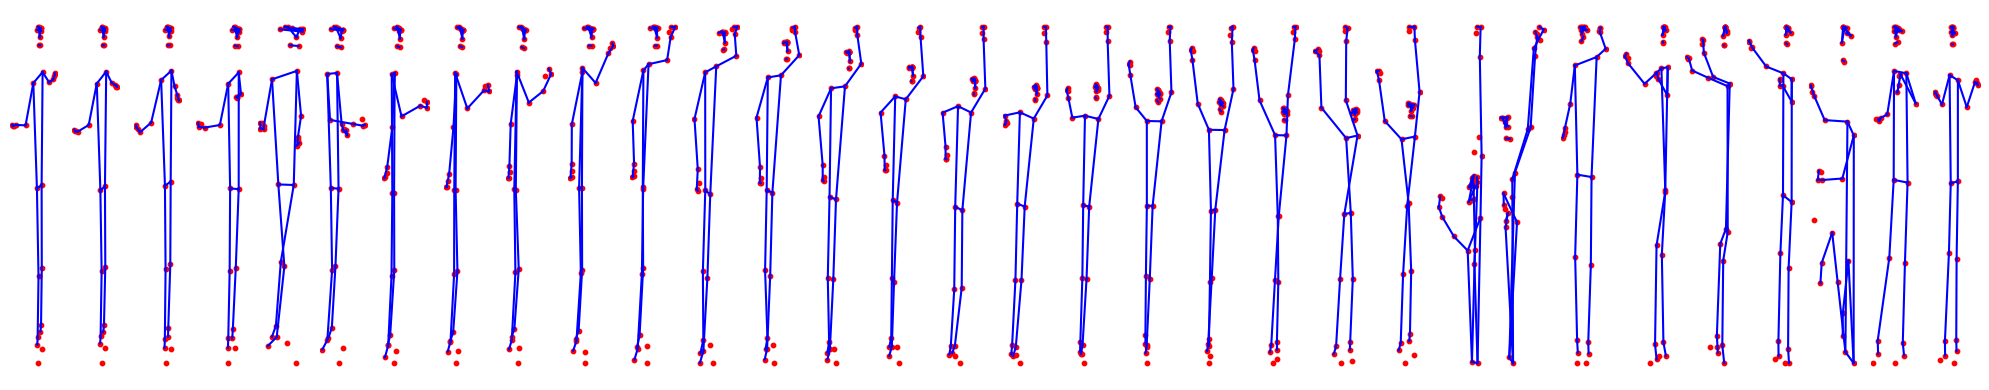

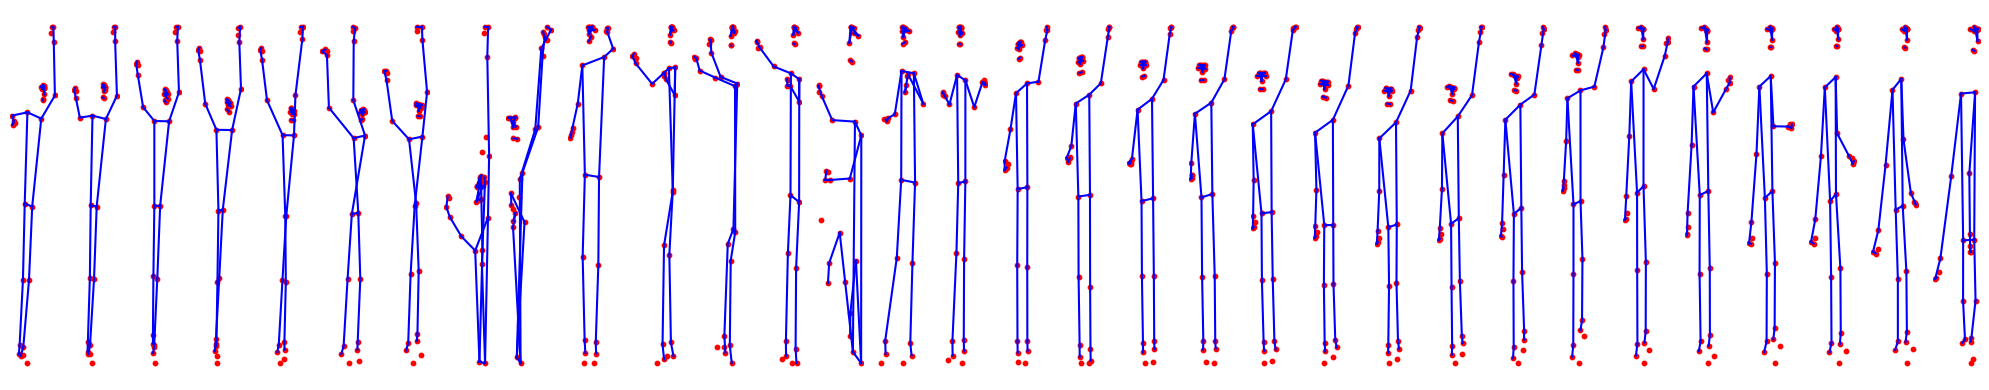

In [37]:
# Suppose pose_clips is the result of create_clips()
for i in range(5):
    sample_clip = pose_clips[i]
    show_pose_clip(sample_clip)